In [1]:
import sys
from pathlib import Path
# Set path for external modules
code_dir = Path("../utils").resolve()
if str(code_dir) not in sys.path:
    sys.path.insert(0, str(code_dir))
import copy

import numpy as np

import galsim

import ngmix
import metadetect

import sep

import matplotlib.pyplot as plt

from make_data import *
from noise_utils import *
from shear_meas import *
from metadetect_utils import *

/Users/aguinot/miniconda3/envs/tutorial_metadetect/lib/python3.13/site-packages/metadetect/fitting.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


# Tutorial Metadetection

All the biases corrected by **Metacalibration** can also be corrected by **Metadetection**. This time we will focus on detection effects, which are mainly (but not limited to!) due to blending.

**Metadetection** was first introduce in [Sheldon et al. (2023)](https://arxiv.org/abs/1911.02505) and a first application on data can be seen in [Yamamoto et al. (2025)](https://arxiv.org/abs/2501.05665).

#### Difference with Metacalibration

![title](notebook_data/metacal_to_metadetect_workflow.png)

This time we will apply a shear on a larger image than before, typically $\approx 1~\rm{arcmin}^{2}$. That means that we are making 2 assumptions:
- WCS are considered constant. Cen be represented by a simple Jacobian matrix.
- PSF is considered constant. The PSF defined at the center of the image is a good representation of the PSF at all locations in the image.  

This is the reason why for DES and DESC we see *cell-based* coadds which are smaller than usual coadds **and** only include exposures that are fully contain in the cell foot print, no exposure edges to ensure that the PSF is properlly defined (recently Erin Sheldon has demonstrated that this condition does not need to be enforce and if edges are properly handled they can be included (Sheldon et al. *in prep*)).


#### **Disclaimer**
We will not discuss the redshift dependent bias due to blending of galaxies at different redshift. See [MacCrann, Becker et al. (2022)](https://arxiv.org/abs/2012.08567) for an exhaustive description of the effect and calibration with simulation.

## Why do we need Metadetection?

In [2]:
pixel_scale = 0.2
psf_model = "gauss"
psf_fwhm = 0.6
noise_sigma = 1e-5
separation = 7.

#### Image with positive shear on g1

In [3]:
gal_p, psf, _ = make_data_metadetect_simple(
    separation=separation,
    g1=0.05,
    pixel_scale=pixel_scale,
    psf_model=psf_model,
    psf_fwhm=psf_fwhm,
    noise_sigma=noise_sigma,
    do_shift=False,
)

obj_p = sep.extract(
    gal_p,
    err=noise_sigma,
    thresh=1.5,
)
len(obj_p)

1

#### Image with negative shear on g1

In [4]:
gal_m, psf, _ = make_data_metadetect_simple(
    separation=separation,
    g1=-0.05,
    pixel_scale=pixel_scale,
    psf_model=psf_model,
    psf_fwhm=psf_fwhm,
    noise_sigma=noise_sigma,
    do_shift=False,
)

obj_m = sep.extract(
    gal_m,
    err=noise_sigma,
    thresh=1.5,
)
len(obj_m)

2

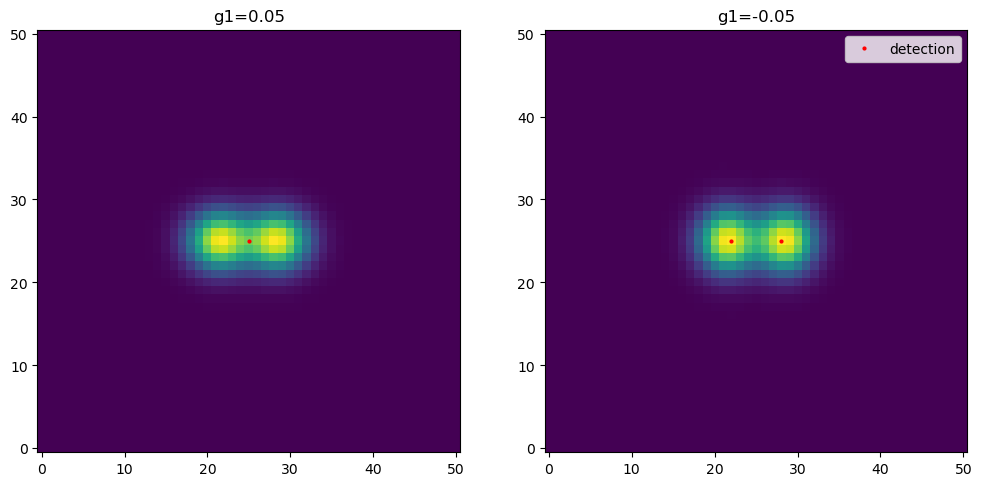

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title("g1=0.05")
axs[0].imshow(gal_p, origin="lower")
axs[0].plot(obj_p['x'], obj_p['y'], 'ro', markersize=2)

axs[1].set_title("g1=-0.05")
axs[1].imshow(gal_m, origin="lower")
axs[1].plot(obj_m['x'], obj_m['y'], 'ro', markersize=2, label="detection")
axs[1].legend()


Here we can see the problem. Depending on the shear, the blend will be detected or not and that would create a bias.

## Metadetection in practice

#### Step 1: Apply Metacalibration

In [6]:
pixel_scale = 0.2
psf_model = "gauss"
psf_fwhm = 0.6
noise_sigma = 1e-5
separation = 25
image_size = 61
rng = np.random.RandomState(42)

gal, psf, _ = make_data_metadetect_simple(
    separation=separation,
    pixel_scale=pixel_scale,
    psf_model=psf_model,
    psf_fwhm=psf_fwhm,
    noise_sigma=noise_sigma,
    image_size=image_size,
    do_shift=False,
)

img_shape = gal.shape
psf_shape = psf.shape

img_center = ((img_shape[1]-1)/2., (img_shape[0]-1)/2.)
psf_center = ((psf_shape[1]-1)/2., (psf_shape[0]-1)/2.)

# Ngmix handles the WCS with a Jacobian transformation
img_jacob = ngmix.DiagonalJacobian(
    row=img_center[1],
    col=img_center[0],
    scale=pixel_scale,
)
psf_jacob = ngmix.DiagonalJacobian(
    row=psf_center[1],
    col=psf_center[0],
    scale=pixel_scale,
)

# We first create a PSF observation
psf_obs = ngmix.Observation(
    image=psf,
    jacobian=psf_jacob,
)

# Then we create the object observation and we pass the PSF observation
obs = ngmix.Observation(
    image=gal,
    weight=np.ones(img_shape) * 1/noise_sigma**2,  # Weights are inverse variance
    jacobian=img_jacob,
    psf=psf_obs,
    bmask=np.zeros(img_shape, dtype=np.int32),
    ormask=np.zeros(img_shape, dtype=np.int32),
)

obs_mcal = ngmix.metacal.get_all_metacal(
    obs,
    psf="fitgauss",
    step=0.01,
    fixnoise=True, # We will see justr after the effect of this
    types=["noshear", "1p"],
    rng=rng,
)

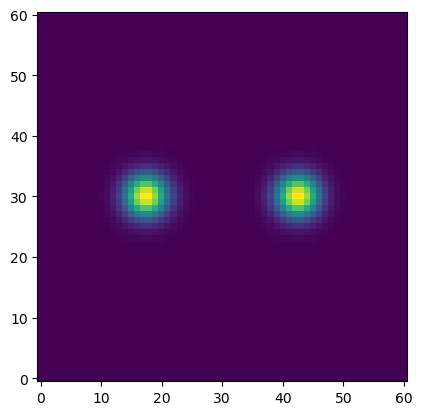

In [7]:
plt.imshow(gal, origin="lower")

#### Step 2: Run detection

In [8]:
det_cat = {}
for shear_type in obs_mcal:
    img = obs_mcal[shear_type].image.copy()
    weight = obs_mcal[shear_type].weight.copy()

    rms = np.sqrt(1. / np.median(weight))

    cat = sep.extract(
        img,
        err=rms,
        thresh=1.5,
    )

    det_cat[shear_type] = cat

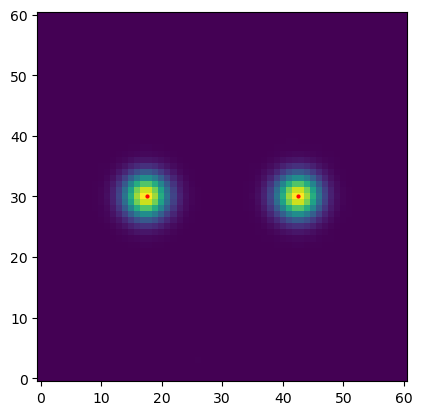

In [9]:
plt.imshow(obs_mcal["noshear"].image, origin="lower")
plt.plot(det_cat["noshear"]['x'], det_cat["noshear"]['y'], 'ro', markersize=2)

#### Step 3: Make cutout around each objects

In [10]:
stamp, row, col, ostart_row, ostart_col, oend_row, oend_col = get_cutout(obs_mcal["noshear"].image, det_cat["noshear"]['x'][0], det_cat["noshear"]['y'][0], 31, return_bounds=True)

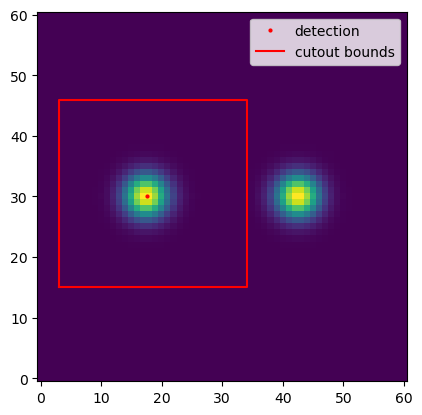

In [11]:
plt.imshow(gal, origin="lower")
plt.plot(det_cat["noshear"]['x'][0], det_cat["noshear"]['y'][0], 'ro', markersize=2, label="detection")
plt.plot([ostart_col, oend_col, oend_col, ostart_col, ostart_col], [ostart_row, ostart_row, oend_row, oend_row, ostart_row], 'r-', label="cutout bounds")
plt.legend()

#### Step 4: Measure the shape

In [12]:
shear_dict = {}
for shear_type in obs_mcal:
    shear_dict[shear_type] = {
        "g1": [],
        "g2": [],
    }
    for cat_obj in det_cat[shear_type]:
        stamp, row, col = get_cutout(obs_mcal[shear_type].image, cat_obj['x'], cat_obj['y'], 31)
        meas_shape = galsim.hsm.EstimateShear(
            galsim.Image(stamp, scale=pixel_scale),
            galsim.Image(obs_mcal[shear_type].psf.image, scale=pixel_scale)
        )
        s = galsim.Shear(e1=meas_shape.corrected_e1, e2=meas_shape.corrected_e2)
        shear_dict[shear_type]["g1"].append(s.g1)
        shear_dict[shear_type]["g2"].append(s.g2)

In [13]:
print("We check that we recover the shear we have applied:")
print(f"Input shear 'noshear':\nn_obj: {len(shear_dict["noshear"]["g1"])}   target: 2\ng1={np.mean(shear_dict["noshear"]["g1"])}   target: 0.0\ng2={np.mean(shear_dict["noshear"]["g2"])}  target: 0.0")
print()
print(f"Input shear '1p':\nn_obj: {len(shear_dict['1p']['g1'])}   target: 2\ng1={np.mean(shear_dict['1p']['g1'])}    target: 0.01\ng2={np.mean(shear_dict['1p']['g2'])}  target: 0.0")

We check that we recover the shear we have applied:
Input shear 'noshear':
n_obj: 2   target: 2
g1=3.567196870596924e-06   target: 0.0
g2=0.00010096954431647856  target: 0.0

Input shear '1p':
n_obj: 2   target: 2
g1=0.009994662701618081    target: 0.01
g2=0.00010306493753342108  target: 0.0


## Now we can do it automatically with metadetect

ngmix works with [**Observation**](https://github.com/esheldon/ngmix/blob/d08b471f4c4d5887df9f9f2551efaf8f2e226150/ngmix/observation.py#L66)

But we can define a list of **Observations** for multiple observation of an object with [**ObsList**](https://github.com/esheldon/ngmix/blob/d08b471f4c4d5887df9f9f2551efaf8f2e226150/ngmix/observation.py#L861), we can also define a list of **ObsList** for observations in multiple bands with [**MultiBandObsList**](https://github.com/esheldon/ngmix/blob/d08b471f4c4d5887df9f9f2551efaf8f2e226150/ngmix/observation.py#L980)

Metadetection take a **MultiBandObsList** as input.


In [14]:
obslist = ngmix.ObsList()
mb_obslist = ngmix.MultiBandObsList()

obslist.append(obs)
mb_obslist.append(obslist)

In [15]:
cfg = copy.deepcopy(TEST_METADETECT_CONFIG)
cfg["model"] = "gauss"
cfg["metacal"]["types"] = ["noshear", "1p", "1m"]

res = metadetect.do_metadetect(
    copy.deepcopy(cfg),
    mb_obslist,
    np.random.RandomState(42),
)

In [16]:
print("We check that we recover the shear we have applied:")
print(f"Input shear 'noshear':\nn_obj: {len(res['noshear']['gauss_g'])}   target: 2\ng1={np.mean(res['noshear']['gauss_g'][:, 0])}   target: 0.0\ng2={np.mean(res['noshear']['gauss_g'][:, 1])}  target: 0.0")
print()
print(f"Input shear '1p':\nn_obj: {len(res['1p']['gauss_g'])}   target: 2\ng1={np.mean(res['1p']['gauss_g'][:, 0])}    target: 0.01\ng2={np.mean(res['1p']['gauss_g'][:, 1])}  target: 0.0")

We check that we recover the shear we have applied:
Input shear 'noshear':
n_obj: 2   target: 2
g1=3.372142056134505e-05   target: 0.0
g2=-0.00014140702351635336  target: 0.0

Input shear '1p':
n_obj: 2   target: 2
g1=0.010007922305633785    target: 0.01
g2=-0.0001387879286537961  target: 0.0
